<a href="https://colab.research.google.com/github/deadastronautda/Project-Alpha/blob/qa_dev/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os

def clean_value(val):
    """Преобразует строку в число: удаляет пробелы, заменяет запятые на точки."""
    if pd.isna(val) or val == '' or val == '-':
        return None
    if isinstance(val, str):
        val = val.strip() # Remove leading/trailing spaces

        # Handle common thousands and decimal separators used in financial data.
        # Assume space or dot are thousands separators, and comma is decimal.
        # OR assume comma is thousands separator, and dot is decimal.

        # Try cleaning as if space/dot are thousands and comma is decimal
        temp_val_comma_decimal = val.replace(' ', '').replace('.', '')
        temp_val_comma_decimal = temp_val_comma_decimal.replace(',', '.')

        # Try cleaning as if comma is thousands and dot is decimal
        temp_val_dot_decimal = val.replace(',', '').replace(' ', '')
        # The dot is already the decimal separator in this case

        # Check which conversion works, prioritizing the format where comma is decimal if both are present.
        try:
            return float(temp_val_comma_decimal)
        except ValueError:
            try:
                return float(temp_val_dot_decimal)
            except ValueError:
                # If both common patterns failed, try a stricter cleaning: remove all non-digits except a single dot
                cleaned_val_strict = re.sub(r'[^\d\.]', '', val)
                if cleaned_val_strict.count('.') <= 1:
                    try:
                        return float(cleaned_val_strict)
                    except ValueError:
                         return None
                else:
                    return None # Still multiple dots

    return float(val)

def load_financial_report(file_path: str) -> pd.DataFrame:
    """
    Загружает финансовый отчёт из Excel-файла и возвращает нормализованный DataFrame.
    Ожидается, что данные начинаются с показателя "Нематериальные активы".
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл не найден: {file_path}")

    # Загружаем все строки как строки, чтобы избежать автоматического преобразования
    df_raw = pd.read_excel(file_path, header=None, dtype=str)
    #print("df_raw head:\n", df_raw.head(10))

    # Поиск начала таблицы по ключевому слову "Нематериальные активы"
    start_row = None
    for idx, row in df_raw.iterrows():
        if 'Нематериальные активы' in str(row.iloc[0]):
            start_row = idx

            break

    if start_row is None:
        raise ValueError("Не найдено начало финансовой отчётности в файле.")
    #print(f"Start row found at index: {start_row}")

    # Поиск строки с заголовками годов перед или начиная с start_row
    header_row = None
    # Search backwards from start_row up to a few rows (e.g., 10 rows) or the beginning of the file
    search_start = max(0, start_row - 10)
    for idx in range(start_row, search_start -1 , -1): # Search backwards
        row = df_raw.iloc[idx]
        # Check if any value in the row (after the first few columns) can be interpreted as a year
        if any(pd.notna(col) and str(col).isdigit() and int(str(col)) > 1900 for col in row.iloc[3:]):
            header_row = idx
            break

    if header_row is None:
         raise ValueError("Не найдена строка с заголовками годов перед или начиная с начала финансовой отчётности.")
    #print(f"Header row found at index: {header_row}")

    # Extract the actual header row with years
    header_row_data = df_raw.iloc[header_row]
    header = ['Показатель', 'Код', 'Ед. изм.'] + [str(int(float(col))) if pd.notna(col) and str(col).replace('.','',1).isdigit() else col for col in header_row_data.iloc[3:] if pd.notna(col)]
    #print("Generated header:", header)

    # The data rows start from the row after the header row
    data_rows = df_raw.iloc[header_row + 1:].copy() # Use copy to avoid SettingWithCopyWarning
    # Preserve original column indices
    original_data_columns = data_rows.columns


    # The first three columns of data_rows are Показатель, Код, Ед. изм.
    # The rest are year data
    df = pd.DataFrame()
    df['Показатель'] = data_rows[original_data_columns[0]] # Use original column indices
    df['Код'] = data_rows[original_data_columns[1]]
    df['Ед. изм.'] = data_rows[original_data_columns[2]]


    # Map the year columns from the header to the correct original column indices in df_raw
    year_to_original_col_map = {}
    # Iterate through the original column indices in the header row data
    for original_col_idx, header_val in header_row_data.iloc[3:].items():
        if pd.notna(header_val):
            try:
                year = str(int(float(str(header_val).replace('.','',1).replace(',','',1))))
                if int(year) > 1900:
                    year_to_original_col_map[year] = original_col_idx
            except ValueError:
                pass # Not a year

    #print("Year to original column map:", year_to_original_col_map)

    for year in header[3:]:
        if year in year_to_original_col_map:
            original_col_index = year_to_original_col_map[year]
            # Check if this original column index exists in data_rows' columns
            if original_col_index in data_rows.columns:
                 df[year] = data_rows[original_col_index].apply(clean_value)
            else:
                 df[year] = None # Handle cases where a year column might be missing in data_rows

        else:
            df[year] = None # Should not happen if header was correctly parsed


    # Удаляем строки с пустыми показателями
    df = df.dropna(subset=['Показатель']).reset_index(drop=True)
    df['Показатель'] = df['Показатель'].str.strip()

    return df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Предполагается использование seaborn для улучшения эстетики графиков

def clean_value(val):
    """Преобразует строку в число: удаляет пробелы, заменяет запятые на точки."""
    if pd.isna(val) or val == '' or val == '-':
        return None
    if isinstance(val, str):
        val = val.strip() # Удаляем пробелы в начале и конце строки

        # Обрабатываем распространенные разделители тысяч и десятичные разделители в финансовых данных.
        # Предполагаем, что пробел или точка - разделители тысяч, а запятая - десятичный разделитель.
        # ИЛИ предполагаем, что запятая - разделитель тысяч, а точка - десятичный разделитель.

        # Попытка очистки, предполагая, что пробел/точка - разделители тысяч, а запятая - десятичный
        temp_val_comma_decimal = val.replace(' ', '').replace('.', '')
        temp_val_comma_decimal = temp_val_comma_decimal.replace(',', '.')

        # Попытка очистки, предполагая, что запятая - разделитель тысяч, а точка - десятичный
        temp_val_dot_decimal = val.replace(',', '').replace(' ', '')
        # Точка уже является десятичным разделителем в этом случае

        # Проверяем, какое преобразование работает, отдавая приоритет формату, где запятая - десятичный разделитель, если присутствуют оба.
        try:
            return float(temp_val_comma_decimal)
        except ValueError:
            try:
                return float(temp_val_dot_decimal)
            except ValueError:
                # Если оба распространенных шаблона не сработали, пробуем более строгую очистку: удаляем все нецифры, кроме одной точки
                cleaned_val_strict = re.sub(r'[^\d\.]', '', val)
                if cleaned_val_strict.count('.') <= 1:
                    try:
                        return float(cleaned_val_strict)
                    except ValueError:
                         return None
                else:
                    return None # Все еще несколько точек

    # Если входное значение уже было числового типа, просто возвращаем его как float
    try:
        return float(val)
    except ValueError:
         return None


def load_financial_report(file_path: str) -> pd.DataFrame:
    """
    Загружает финансовый отчёт из Excel-файла и возвращает нормализованный DataFrame.
    Ожидается, что данные начинаются с показателя "Нематериальные активы".
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл не найден: {file_path}")

    # Загружаем все строки как строки, чтобы избежать автоматического преобразования
    df_raw = pd.read_excel(file_path, header=None, dtype=str)
    # print("df_raw head:\n", df_raw.head(10)) # Отладочный вывод

    # Поиск начала таблицы по ключевому слову "Нематериальные активы"
    start_row = None
    for idx, row in df_raw.iterrows():
        if 'Нематериальные активы' in str(row.iloc[0]):
            start_row = idx

            break

    if start_row is None:
        raise ValueError("Не найдено начало финансовой отчётности в файле.")
    # print(f"Start row found at index: {start_row}") # Отладочный вывод

    # Поиск строки с заголовками годов перед или начиная с start_row
    header_row = None
    # Ищем назад от start_row до нескольких строк (например, 10) или до начала файла
    search_start = max(0, start_row - 10)
    for idx in range(start_row, search_start -1 , -1): # Ищем назад по строкам
        row = df_raw.iloc[idx]
        # Проверяем, может ли какое-либо значение в строке (после первых нескольких колонок) быть интерпретировано как год
        if any(pd.notna(col) and str(col).isdigit() and int(str(col)) > 1900 for col in row.iloc[3:]):
            header_row = idx
            break

    if header_row is None:
         raise ValueError("Не найдена строка с заголовками годов перед или начиная с начала финансовой отчётности.")
    # print(f"Header row found at index: {header_row}") # Отладочный вывод

    # Извлекаем заголовки: первые 3 колонки — метаданные, остальные — годы
    # Извлекаем фактическую строку заголовка с годами
    header_row_data = df_raw.iloc[header_row]
    header = ['Показатель', 'Код', 'Ед. изм.'] + [str(int(float(col))) if pd.notna(col) and str(col).replace('.','',1).isdigit() else col for col in header_row_data.iloc[3:] if pd.notna(col)]
    # print("Generated header:", header) # Отладочный вывод

    # Строки данных начинаются со строки после строки заголовка
    data_rows = df_raw.iloc[header_row + 1:].copy() # Используем copy чтобы избежать SettingWithCopyWarning
    # Сохраняем исходные индексы колонок
    original_data_columns = data_rows.columns


    # Первые три колонки data_rows — это Показатель, Код, Ед. изм.
    # Остальные — данные по годам
    df = pd.DataFrame()
    df['Показатель'] = data_rows[original_data_columns[0]] # Используем исходные индексы колонок
    df['Код'] = data_rows[original_data_columns[1]]
    df['Ед. изм.'] = data_rows[original_data_columns[2]]


    # Сопоставляем колонки годов из заголовка с соответствующими исходными индексами колонок в df_raw
    year_to_original_col_map = {}
    # Итерируем по исходным индексам колонок в данных строки заголовка
    for original_col_idx, header_val in header_row_data.iloc[3:].items():
        if pd.notna(header_val):
            try:
                # Пытаемся преобразовать значение заголовка в год
                year = str(int(float(str(header_val).replace('.','',1).replace(',','',1))))
                if int(year) > 1900:
                    year_to_original_col_map[year] = original_col_idx
            except ValueError:
                pass # Не является годом

    # print("Year to original column map:", year_to_original_col_map) # Отладочный вывод

    for year in header[3:]:
        if year in year_to_original_col_map:
            original_col_index = year_to_original_col_map[year]
            # Проверяем, существует ли этот исходный индекс колонки в колонках data_rows
            if original_col_index in data_rows.columns:
                 df[year] = data_rows[original_col_index].apply(clean_value)
            else:
                 df[year] = None # Обрабатываем случаи, когда колонка года может отсутствовать в data_rows

        else:
            df[year] = None # Не должно произойти, если заголовок был правильно разобран


    # Удаляем строки с пустыми показателями
    df = df.dropna(subset=['Показатель']).reset_index(drop=True)
    df['Показатель'] = df['Показатель'].str.strip()

    # print("DataFrame before return:\n", df) # Отладочный вывод

    return df


def calculate_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитывает ключевые финансовые коэффициенты по годам.
    Возвращает DataFrame с годами в колонках и коэффициентами в строках.
    """
    # Определяем колонки с годами (ожидаем, что они строковые и представляют собой числа >= 1900)
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort() # Сортируем года по возрастанию

    if not years:
        print("Предупреждение: Годовые колонки не найдены в DataFrame.")
        return pd.DataFrame() # Возвращаем пустой DataFrame если года не найдены

    ratios = {}

    def get_value(pattern):
        # Ищем строку, где 'Показатель' содержит искомое название (регистронезависимо)
        row = df[df['Показатель'].str.contains(pattern, case=False, na=False)]
        if not row.empty:
            # Выбираем только колонки годов и преобразуем их в числовой тип, принудительно преобразуя ошибки в NaN
            # Используем .infer_objects(copy=False) или преобразуем явно для избежания предупреждений pandas
            return row.iloc[0][years].infer_objects(copy=False).fillna(0).values # Добавляем infer_objects и fillna
        # print(f"Предупреждение: Показатель '{pattern}' не найден.") # Оставляем закомментированным для более чистого вывода
        return np.zeros(len(years))

    # Извлечение необходимых показателей
    revenue = get_value(r'^Выручка') # Используем regex для точного совпадения начала строки
    # Используем regex для поиска "Чистая прибыль" с возможными словами в скобках
    net_profit = get_value(r'^Чистая прибыль')
    total_assets = get_value(r'^БАЛАНС \(актив\)') # Экранируем скобки
    # Ищем "Итого по разделу III" с возможным продолжением
    equity = get_value(r'^Итого по разделу III')
    # Ищем "Итого по разделу V" с возможным продолжением
    short_debt = get_value(r'^Итого по разделу V')
    # Ищем "Итого по разделу II" с возможным продолжением
    current_assets = get_value(r'^Итого по разделу II')
    # Ищем "Итого по разделу IV" с возможным продолжением
    long_debt = get_value(r'^Итого по разделу IV')


    # Расчет коэффициентов. Используем np.divide для безопасного деления на ноль.
    # ROA = Чистая прибыль / Активы
    roa = np.divide(net_profit, total_assets, out=np.zeros_like(net_profit), where=total_assets!=0)
    # ROE = Чистая прибыль / Собственный капитал
    roe = np.divide(net_profit, equity, out=np.zeros_like(net_profit), where=equity!=0)
    # Текущая ликвидность = Оборотные активы / Краткосрочные обязательства
    current_ratio = np.divide(current_assets, short_debt, out=np.zeros_like(current_assets), where=short_debt!=0)
    # Маржа чистой прибыли = Чистая прибыль / Выручка
    net_margin = np.divide(net_profit, revenue, out=np.zeros_like(net_profit), where=revenue!=0)

    # Добавляем рассчитанные коэффициенты и извлеченные показатели в словарь
    ratios['ROA (Рентабельность активов)'] = roa
    ratios['ROE (Рентабельность капитала)'] = roe
    ratios['Текущая ликвидность'] = current_ratio
    ratios['Маржа чистой прибыли'] = net_margin
    # Выручка и Чистая прибыль в млн руб. (исходные данные в тыс. руб.)
    ratios['Выручка (млн руб.)'] = revenue / 1000
    ratios['Чистая прибыль (млн руб.)'] = net_profit / 1000
    # Добавляем активы, собственный капитал и задолженность в млн руб. для полноты
    ratios['Активы (млн руб.)'] = total_assets / 1000
    ratios['Собственный капитал (млн руб.)'] = equity / 1000
    ratios['Краткосрочные обязательства (млн руб.)'] = short_debt / 1000
    ratios['Долгосрочные обязательства (млн руб.)'] = long_debt / 1000
    ratios['Оборотные активы (млн руб.)'] = current_assets / 1000


    # Создаем DataFrame из словаря, где ключи - названия коэффициентов/показателей,
    # а значения - массивы данных по годам. Индексами будут названия, колонками - года.
    ratios_df = pd.DataFrame(ratios, index=years).T

    return ratios_df

def plot_key_metrics(df: pd.DataFrame):
    """
    Строит графики ключевых финансовых показателей (Выручка, Чистая прибыль, Активы) по годам.
    Принимает нормализованный DataFrame финансовой отчетности.
    """
    # Определяем колонки с годами (ожидаем, что они строковые и представляют собой числа >= 1900)
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort() # Сортируем года по возрастанию

    if not years:
        print("Не найдены годовые колонки для построения графиков.")
        return

    # Извлечение данных для графиков
    def get_metric_series(indicator_pattern):
        row = df[df['Показатель'].str.contains(indicator_pattern, case=False, na=False)]
        if not row.empty:
            # Выбираем только колонки годов и преобразуем их в числовой тип, принудительно преобразуя ошибки в NaN
            metric_series = row.iloc[0][years].apply(pd.to_numeric, errors='coerce')
            # Преобразуем индекс (года как строки) в datetime для лучшего отображения на графике
            metric_series.index = pd.to_datetime(metric_series.index)
            return metric_series
        # print(f"Предупреждение: Показатель '{indicator_pattern}' не найден для построения графика.") # Оставляем закомментированным
        return pd.Series(index=pd.to_datetime(years)) # Возвращаем пустую серию с datetime индексом


    # Извлекаем необходимые ряды данных
    revenue_series = get_metric_series(r'^Выручка')
    net_profit_series = get_metric_series(r'^Чистая прибыль')
    total_assets_series = get_metric_series(r'^БАЛС \(актив\)') # Убедимся, что паттерн соответствует данным


    # Построение графиков
    plt.figure(figsize=(14, 7))

    # График Выручки
    if not revenue_series.empty:
        plt.plot(revenue_series.index, revenue_series.values, marker='o', linestyle='-', label='Выручка (тыс. руб.)')

    # График Чистой прибыли
    if not net_profit_series.empty:
        plt.plot(net_profit_series.index, net_profit_series.values, marker='o', linestyle='-', label='Чистая прибыль (тыс. руб.)')

    # График Активов
    if not total_assets_series.empty:
        plt.plot(total_assets_series.index, total_assets_series.values, marker='o', linestyle='-', label='Активы (тыс. руб.)')


    plt.title('Динамика ключевых финансовых показателей')
    plt.xlabel('Год')
    plt.ylabel('Сумма (тыс. руб.)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_ratios(df_ratios: pd.DataFrame):
    """
    Строит графики финансовых коэффициентов по годам.
    Принимает DataFrame с рассчитанными коэффициентами (результат calculate_ratios).
    """
    if df_ratios.empty:
        print("DataFrame с коэффициентами пуст. Невозможно построить графики.")
        return

    # Транспонируем DataFrame, чтобы года стали индексом для построения графиков
    df_plot = df_ratios.T
    # Преобразуем индекс (года) в datetime для лучшего отображения на графике
    df_plot.index = pd.to_datetime(df_plot.index)

    # Определяем, какие коэффициенты нужно построить
    ratios_to_plot = ['ROA (Рентабельность активов)', 'ROE (Рентабельность капитала)',
                      'Текущая ликвидность', 'Маржа чистой прибыли']

    plt.figure(figsize=(14, 8))

    for ratio in ratios_to_plot:
        if ratio in df_plot.columns:
            # Используем seaborn для более красивых графиков
            sns.lineplot(data=df_plot, x=df_plot.index, y=ratio, marker='o', linestyle='-', label=ratio)
        # else:
            # print(f"Предупреждение: Коэффициент '{ratio}' не найден в DataFrame.") # Оставляем закомментированным


    plt.title('Динамика ключевых финансовых коэффициентов')
    plt.xlabel('Год')
    plt.ylabel('Значение коэффициента')
    plt.xticks(rotation=45)
    plt.legend(title='Коэффициенты') # Добавляем заголовок легенды
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def detect_anomalies(df: pd.DataFrame, threshold=2.5):
    """
    Выявляет аномалии в динамике ключевых финансовых показателей с использованием метода Z-score.

    Принимает нормализованный DataFrame финансовой отчетности и порог Z-score.
    Возвращает словарь с показателями и списками годов, в которых были обнаружены аномалии.
    """
    # Определяем колонки с годами
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort()

    if not years:
        # print("Не найдены годовые колонки для выявления аномалий.") # Оставляем закомментированным
        return {}

    anomalies_found = {}

    # Показатели, для которых ищем аномалии
    indicators_to_check = {
        'Выручка': r'^Выручка',
        'Чистая прибыль': r'^Чистая прибыль',
        'Активы': r'^БАЛАНС \(актив\)'
        # Можно добавить другие показатели по необходимости
    }

    for indicator_name, indicator_pattern in indicators_to_check.items():
        # Ищем строку с показателем (регистронезависимо)
        indicator_row = df[df['Показатель'].str.contains(indicator_pattern, case=False, na=False)]

        if indicator_row.empty:
            # print(f"Показатель '{indicator_name}' не найден для выявления аномалий.") # Оставляем закомментированным
            continue

        # Выбираем только колонки годов и преобразуем их в числовой тип, принудительно преобразуя ошибки в NaN
        data_series = indicator_row.iloc[0][years].apply(pd.to_numeric, errors='coerce')
        data_series = data_series.dropna() # Удаляем значения NaN перед расчетом Z-оценок

        if len(data_series) < 2: # Необходимо как минимум 2 точки данных для расчета стандартного отклонения
            # print(f"Недостаточно данных для выявления аномалий в '{indicator_name}'.") # Оставляем закомментированным
            continue

        # Расчет Z-оценок, обрабатываем случаи с нулевым стандартным отклонением
        mean = data_series.mean()
        std_dev = data_series.std()

        if std_dev == 0:
             # print(f"Стандартное отклонение для '{indicator_name}' равно нулю. Аномалии не выявлены.") # Оставляем закомментированным
             continue # Нет аномалий, если стандартное отклонение равно нулю

        z_scores = np.abs((data_series - mean) / std_dev)
        # Находим индексы (года) тех значений, Z-оценка которых превышает порог
        anomalies = data_series[z_scores > threshold].index.tolist()

        if anomalies:
            anomalies_found[indicator_name] = anomalies

    return anomalies_found

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_key_metrics(df: pd.DataFrame, save_path: str = None):
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Ключевые финансовые показатели ООО "Агрисовгаз" (2009–2024)', fontsize=16)

    years = [col for col in df.columns if col.isdigit()]
    revenue = df[df['Показатель'] == 'Выручка'][years].iloc[0] / 1000
    profit = df[df['Показатель'] == 'Чистая прибыль (убыток)'][years].iloc[0] / 1000
    assets = df[df['Показатель'] == 'БАЛАНС (актив)'][years].iloc[0] / 1000
    equity = df[df['Показатель'] == 'Итого по разделу III - Капитал и резервы'][years].iloc[0] / 1000

    axes[0,0].plot(years, revenue, marker='o', color='green')
    axes[0,0].set_title('Выручка (млн руб.)')
    axes[0,0].tick_params(axis='x', rotation=45)

    axes[0,1].plot(years, profit, marker='o', color='blue')
    axes[0,1].set_title('Чистая прибыль (млн руб.)')
    axes[0,1].tick_params(axis='x', rotation=45)

    axes[1,0].plot(years, assets, label='Активы', marker='o')
    axes[1,0].plot(years, equity, label='Собственный капитал', marker='o')
    axes[1,0].set_title('Активы и капитал (млн руб.)')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)

    debt_short = df[df['Показатель'] == 'Итого по разделу V - Краткосрочные обязательства'][years].iloc[0] / 1000
    debt_long = df[df['Показатель'] == 'Итого по разделу IV - Долгосрочные обязательства'][years].iloc[0] / 1000
    axes[1,1].stackplot(years, debt_short, debt_long, labels=['Краткосрочные', 'Долгосрочные'])
    axes[1,1].set_title('Задолженность (млн руб.)')
    axes[1,1].legend(loc='upper left')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_ratios(ratios_df: pd.DataFrame, save_path: str = None):
    ratios_df_t = ratios_df.T
    fig, ax = plt.subplots(figsize=(12, 6))
    ratios_df_t[['ROA (Рентабельность активов)', 'ROE (Рентабельность капитала)', 'Маржа чистой прибыли']].plot(ax=ax, marker='o')
    ax.set_title('Рентабельность и маржа (2009–2024)')
    ax.set_ylabel('Доли единицы')
    ax.grid(True)
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [ ]:
# Установка библиотеки для чтения файлов .xlsx
!pip install openpyxl

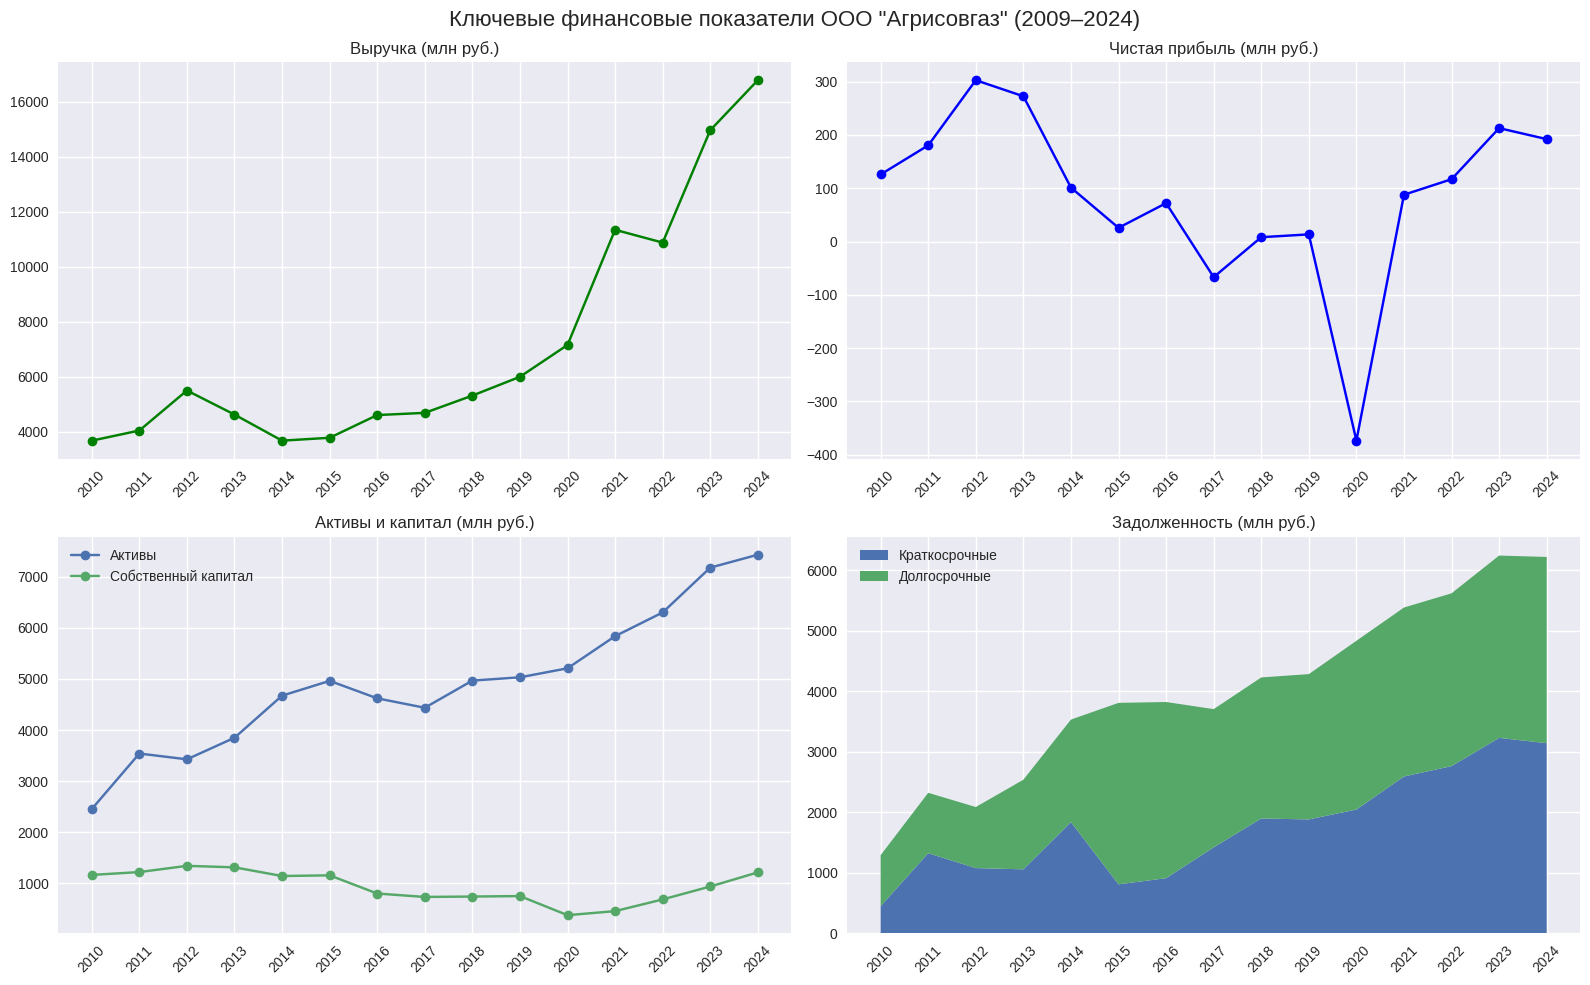

In [ ]:
# Visualize key financial metrics
try:
    plot_key_metrics(df_financial)
except NameError:
    print("Переменная 'df_financial' не найдена. Убедитесь, что вы загрузили финансовый отчёт.")
except Exception as e:
    print(f"Произошла ошибка при построении графиков: {e}")

# Анализ финансовой отчетности ООО "Агрисовгаз"

Данный ноутбук содержит код для загрузки, обработки и анализа финансовой отчетности компании ООО "Агрисовгаз" на основе данных из Excel-файла, полученного с сайта List-Org.

## Описание проекта

Проект направлен на проведение комплексного статистического анализа финансовых данных компании для выявления ключевых показателей, трендов и потенциальных аномалий. Результаты анализа включают расчет финансовых коэффициентов, анализ структуры баланса и визуализацию ключевых показателей.

## Файлы

- `company_4991 (1).xlsx`: Исходный файл финансовой отчетности.

## Использование

1.  **Загрузите ноутбук** в Google Colab или Visual Studio Code.
2.  **Загрузите файл** `company_4991 (1).xlsx` в Google Drive и укажите правильный путь к файлу в соответствующей ячейке кода.
3.  **Выполните ячейки кода** последовательно для:
    *   Определения вспомогательных функций (`clean_value`, `load_financial_report`, `calculate_ratios`, `plot_key_metrics`, `plot_ratios`, `detect_anomalies`).
    *   Загрузки финансовых данных.
    *   Расчета финансовых коэффициентов.
    *   Анализа структуры баланса и ликвидности.
    *   Визуализации ключевых показателей, структуры баланса и финансовых коэффициентов.
    *   Выявления аномалий (при необходимости).
    *   Запуска юнит-тестов для проверки корректности функций.
4.  **Анализируйте выводимые таблицы и графики** для получения инсайтов о финансовом состоянии компании.

## Структура кода

Код организован в виде модулей (функций) для выполнения конкретных задач:

-   `clean_value`: Очистка и преобразование строковых числовых значений.
-   `load_financial_report`: Загрузка и нормализация данных из Excel-файла.
-   `calculate_ratios`: Расчет основных финансовых коэффициентов.
-   `analyze_liquidity_and_structure`: Анализ структуры активов и пассивов и ликвидности.
-   `plot_key_metrics`: Построение графиков ключевых финансовых показателей.
-   `plot_ratios`: Построение графиков финансовых коэффициентов.
-   `detect_anomalies`: Выявление аномалий в данных.
-   Юнит-тесты (`test_...` функции) для проверки функций.

## Требования

-   Python 3.7+
-   Библиотеки: pandas, numpy, matplotlib, seaborn, openpyxl (для чтения .xlsx).

Для установки необходимых библиотек в Colab выполните:

In [ ]:
import pytest
import pandas as pd
import numpy as np
import os

# Добавляем тест для calculate_ratios
def test_calculate_ratios():
    """
    Тест для функции calculate_ratios.
    Создает тестовый нормализованный DataFrame и проверяет расчет коэффициентов.
    """
    # Создаем тестовый нормализованный DataFrame, который имитирует вывод load_financial_report
    test_data = [
        ["Показатель", "Код", "Ед. изм.", 2023, 2024], # Строка заголовка
        ["Выручка", "Ф2.2110", "тыс. руб.", "3,500,000", "4,000,000"],
        ["Чистая прибыль (убыток)", "Ф2.2400", "тыс. руб.", "500,000", "600,000"],
        ["БАЛАНС (актив)", "Ф1.1600", "тыс. руб.", "1,000,000", "1,200,000"],
        ["Итого по разделу III - Капитал и резервы", "Ф1.1300", "тыс. руб.", "1,500,000", "1,800,000"],
        ["Итого по разделу V - Краткосрочные обязательства", "Ф1.1500", "тыс. руб.", "1,000,000", "1,000,000"],
        ["Итого по разделу II - Оборотные активы", "Ф1.1200", "тыс. руб.", "900,000", "1,000,000"], # Добавлен для теста текущей ликвидности
        ["Итого по разделу IV - Долгосрочные обязательства", "Ф1.1400", "тыс. руб.", "500,000", "600,000"]
    ]

    df_test = pd.DataFrame(test_data)
    test_file_path_realistic = "test_report_realistic.xlsx"
    df_test.to_excel(test_file_path_realistic, index=False, header=False)

    # Загружаем данные с использованием load_financial_report
    df_realistic = load_financial_report(test_file_path_realistic)

    # print("df_realistic перед проверками:\n", df_realistic) # Добавить отладочный вывод

    assert "2023" in df_realistic.columns
    assert "2024" in df_realistic.columns

    # Проверяем очищенные значения для конкретных показателей и годов
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2023'].iloc[0] == 3500000.0
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2024'].iloc[0] == 4000000.0
    assert df_realistic[df_realistic['Показатель'] == 'БАЛАНС (актив)']['2023'].iloc[0] == 1000000.0
    assert df_realistic[df_realistic['Показатель'] == 'Чистая прибыль (убыток)']['2024'].iloc[0] == 600000.0

    # Очистка тестовых файлов
    if os.path.exists(test_file_path_realistic):
        os.remove(test_file_path_realistic)

# Включаем определение calculate_ratios (предполагается, что оно уже определено в предыдущей ячейке)
# from __main__ import calculate_ratios # Пример импорта, если функции в разных ячейках

# Предполагая test_clean_value и test_load_financial_report определены в предыдущих ячейках.
# Запускаем все тесты
# test_clean_value() # Раскомментируйте для запуска теста clean_value
# test_load_financial_report() # Раскомментируйте для запуска теста load_financial_report
# test_calculate_ratios() # Раскомментируйте для запуска теста calculate_ratios
# print("Все тесты выполнены!")

In [ ]:
# Create a requirements.txt file
requirements = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "openpyxl"
]

with open("requirements.txt", "w") as f:
    for package in requirements:
        f.write(package + "\\n")

print("Файл requirements.txt успешно создан.")

Файл requirements.txt успешно создан.


# Анализ финансовой отчетности ООО "Агрисовгаз"

## Описание проекта

Данный проект представляет собой Python-код (в формате ноутбука Jupyter/Colab) для автоматизированной загрузки, обработки и комплексного анализа финансовой отчетности компании ООО "Агрисовгаз". Отчетность взята из открытых источников (на примере данных с list-org.com).

Цель проекта: провести статистический анализ финансовых данных, рассчитать ключевые показатели и коэффициенты, выявить тренды и потенциальные аномалии для получения инсайтов о финансовом состоянии и динамике компании.

## Особенности

-   Автоматическая загрузка данных из Excel-файла (`.xlsx`).
-   Гибкая функция очистки числовых данных с различными форматами разделителей.
-   Нормализация структуры данных для удобства анализа.
-   Расчет основных финансовых коэффициентов (рентабельность активов, рентабельность капитала, текущая ликвидность, маржа чистой прибыли и др.).
-   Анализ структуры активов и пассивов баланса.
-   Визуализация ключевых финансовых показателей, структуры баланса и коэффициентов.
-   Простой метод выявления аномалий в динамике показателей (на основе Z-score).
-   Код полностью на русском языке (комментарии, названия графиков и таблиц).

## Требования

Для запуска кода необходимы следующие библиотеки Python:

-   `pandas`
-   `numpy`
-   `matplotlib`
-   `seaborn`
-   `openpyxl`

Вы можете установить их с помощью pip:

In [ ]:
!ssh-keygen -t rsa -b 4096 -C "any_keys"

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 

In [ ]:
# Detect anomalies in the financial data
try:
    # Assuming df_financial is available from a previous cell execution
    if 'df_financial' in locals() and not df_financial.empty:
        print("Выявление аномалий в финансовых данных...")
        anomalies_found = detect_anomalies(df_financial)

        if anomalies_found:
            print("\nОбнаружены потенциальные аномалии (на основе Z-score):")
            for indicator, years in anomalies_found.items():
                print(f"- {indicator}: годы {', '.join(years)}")
        else:
            print("\nАномалии не обнаружены (на основе заданного порога Z-score).")

    else:
        print("DataFrame с финансовыми данными (df_financial) не найден или пуст. Пожалуйста, сначала загрузите файл.")

except NameError:
    print("Переменная 'df_financial' не найдена. Убедитесь, что вы загрузили финансовый отчёт.")
except Exception as e:
    print(f"Произошла ошибка при выявлении аномалий: {e}")

Выявление аномалий в финансовых данных...

Обнаружены потенциальные аномалии (на основе Z-score):
- Чистая прибыль: годы 2020


Визуализация финансовых коэффициентов...


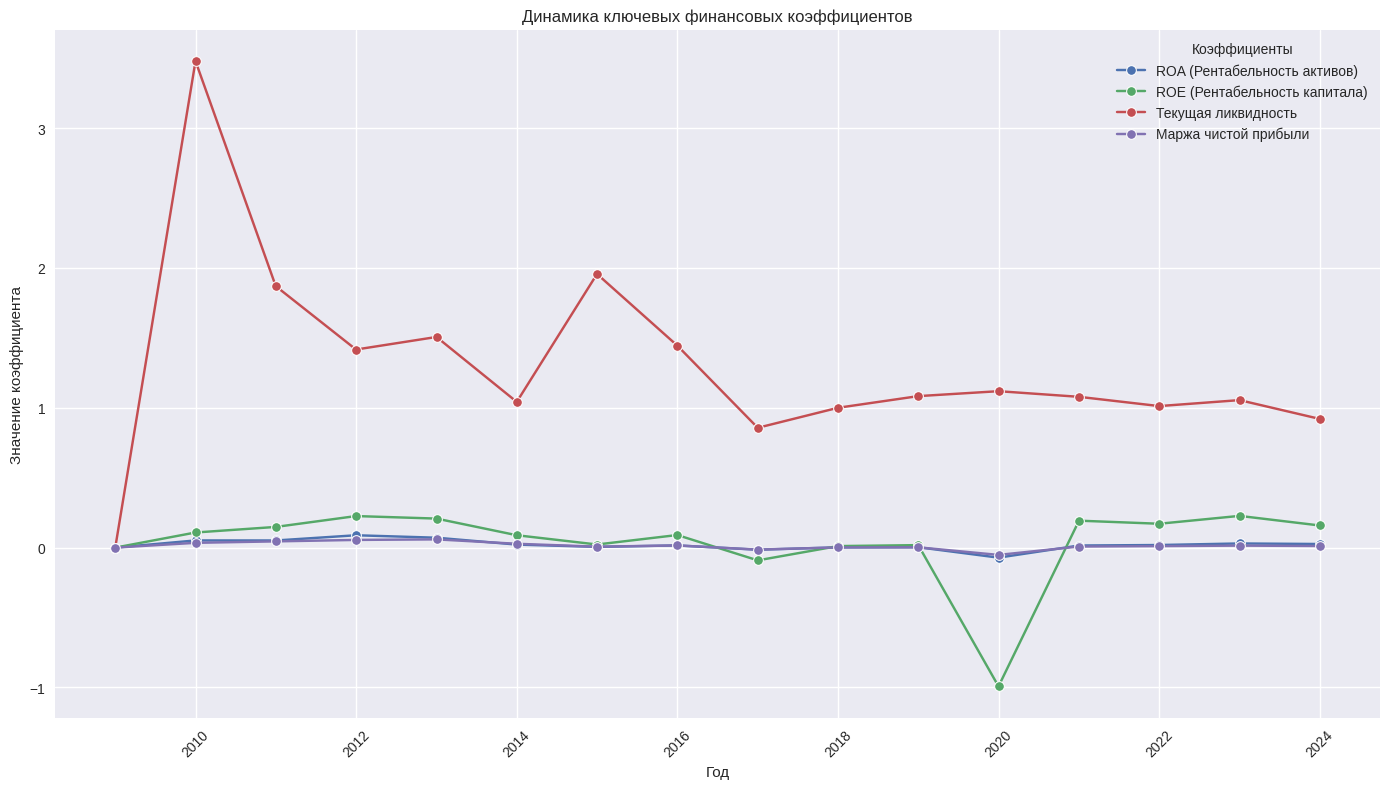

In [ ]:
# Visualize financial ratios using the updated plot_ratios function
try:
    # Assuming df_ratios is available from a previous cell execution
    if 'df_ratios' in locals() and not df_ratios.empty:
        print("Визуализация финансовых коэффициентов...")
        plot_ratios(df_ratios)
    else:
        print("DataFrame с финансовыми коэффициентами (df_ratios) не найден или пуст. Пожалуйста, сначала рассчитайте коэффициенты.")
except NameError:
    print("Переменная 'df_ratios' не найдена. Убедитесь, что вы рассчитали финансовые коэффициенты.")
except Exception as e:
    print(f"Произошла ошибка при построении графиков коэффициентов: {e}")

In [ ]:
# Установка библиотеки flake8 для проверки синтаксиса и стиля кода
!pip install flake8

In [ ]:
# Сохраняем текущий ноутбук во временный файл, чтобы flake8 мог получить к нему доступ
!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/company_4991\ \(1\).ipynb --output /tmp/notebook.py

# Запускаем flake8 на извлеченном Python коде
# Исключаем некоторые распространенные предупреждения/ошибки, которые могут быть приемлемы в контексте ноутбука (например, длина строки)
!flake8 /tmp/notebook.py --ignore=E501,W291,W293,E302,E305,F841

# Удаляем временный файл
!rm /tmp/notebook.py

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/company_4991 (1).ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: 

In [ ]:
def analyze_liquidity_and_structure(df: pd.DataFrame) -> pd.DataFrame:
    """
    Анализирует структуру активов (оборотные/внеоборотные) и пассивов (капитал/обязательства)
    предприятия по годам и рассчитывает некоторые показатели ликвидности.

    Принимает нормализованный DataFrame финансовой отчетности.
    Возвращает DataFrame с анализом структуры и ликвидности.
    """
    # Определяем колонки с годами (ожидаем, что они строковые и представляют собой числа >= 1900)
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort() # Сортируем года по возрастанию

    if not years:
        print("Предупреждение: Годовые колонки не найдены в DataFrame для анализа структуры.")
        return pd.DataFrame()

    analysis_data = {}

    # Функция для безопасного извлечения значений по названию показателя
    def get_value(indicator_pattern):
        # Ищем строку, где 'Показатель' содержит искомый шаблон (регистронезависимо)
        row = df[df['Показатель'].str.contains(indicator_pattern, case=False, na=False)]
        if not row.empty:
            # Выбираем только колонки годов и преобразуем их в числовой тип, принудительно преобразуя ошибки в NaN
            return row.iloc[0][years].infer_objects(copy=False).fillna(0).values
        # print(f"Предупреждение: Показатель '{indicator_pattern}' не найден для анализа структуры.") # Оставляем закомментированным
        return np.zeros(len(years))

    # Извлечение необходимых показателей
    # Используем более гибкие паттерны для поиска разделов баланса
    non_current_assets = get_value(r'^Итого по разделу I') # Внеоборотные активы (Раздел I актива)
    current_assets = get_value(r'^Итого по разделу II') # Оборотные активы (Раздел II актива)
    total_assets = get_value(r'^БАЛАНС \(актив\)') # Всего активов (строка Баланс)

    equity = get_value(r'^Итого по разделу III') # Капитал и резервы (Раздел III пассива)
    long_term_liabilities = get_value(r'^Итого по разделу IV') # Долгосрочные обязательства (Раздел IV пассива)
    short_term_liabilities = get_value(r'^Итого по разделу V') # Краткосрочные обязательства (Раздел V пассива)
    total_liabilities_and_equity = get_value(r'^БАЛАНС \(пассив\)') # Всего пассивов (строка Баланс)

    # Убеждаемся, что Сумма активов примерно равна сумме пассивов + капитала
    # Если строка "БАЛАНС (пассив)" отсутствует, используем сумму разделов III, IV, V
    if np.all(total_liabilities_and_equity == 0):
         total_liabilities_and_equity = equity + long_term_liabilities + short_term_liabilities


    # Анализ структуры активов (в тыс. руб. и долях)
    analysis_data['Внеоборотные активы (тыс. руб.)'] = non_current_assets
    analysis_data['Оборотные активы (тыс. руб.)'] = current_assets
    analysis_data['Всего Активов (тыс. руб.)'] = total_assets # Должно совпадать с total_liabilities_and_equity


    # Избегаем деления на ноль при расчете долей
    total_assets_safe = np.where(total_assets == 0, 1e-9, total_assets) # Заменяем 0 на очень маленькое число для безопасного деления
    analysis_data['Доля внеоборотных активов в активах (%)'] = (non_current_assets / total_assets_safe) * 100
    analysis_data['Доля оборотных активов в активах (%)'] = (current_assets / total_assets_safe) * 100


    # Анализ структуры пассивов (в тыс. руб. и долях)
    analysis_data['Собственный капитал (тыс. руб.)'] = equity
    analysis_data['Долгосрочные обязательства (тыс. руб.)'] = long_term_liabilities
    analysis_data['Краткосрочные обязательства (тыс. руб.)'] = short_term_liabilities
    analysis_data['Всего Пассивов (тыс. руб.)'] = total_liabilities_and_equity # Должно совпадать с total_assets

    # Избегаем деления на ноль при расчете долей
    total_liabilities_and_equity_safe = np.where(total_liabilities_and_equity == 0, 1e-9, total_liabilities_and_equity) # Заменяем 0 на очень маленькое число для безопасного деления
    analysis_data['Доля собственного капитала в пассивах (%)'] = (equity / total_liabilities_and_equity_safe) * 100
    analysis_data['Доля долгосрочных обязательств в пассивах (%)'] = (long_term_liabilities / total_liabilities_and_equity_safe) * 100
    analysis_data['Доля краткосрочных обязательств в пассивах (%)'] = (short_term_liabilities / total_liabilities_and_equity_safe) * 100


    # Дополнительные показатели ликвидности (уже есть в calculate_ratios, но можно повторить здесь для полноты анализа структуры)
    # Текущая ликвидность = Оборотные активы / Краткосрочные обязательства
    short_term_liabilities_safe = np.where(short_term_liabilities == 0, 1e-9, short_term_liabilities) # Заменяем 0 на очень маленькое число для безопасного деления
    analysis_data['Коэффициент текущей ликвидности'] = current_assets / short_term_liabilities_safe


    # Создаем DataFrame
    analysis_df = pd.DataFrame(analysis_data, index=years).T

    # Округляем до двух знаков после запятой для процентов и коэффициентов
    for col in analysis_df.index:
        if '(%)' in col or 'Коэффициент' in col:
            analysis_df.loc[col] = analysis_df.loc[col].round(2)


    return analysis_df

# Предполагается, что df_financial уже загружен из реального файла в предыдущей ячейке
if 'df_financial' in locals():
    print("Проведение анализа структуры баланса и ликвидности...")
    df_structure_analysis = analyze_liquidity_and_structure(df_financial)
    display(df_structure_analysis)
else:
    print("DataFrame с финансовыми данными (df_financial) не найден. Пожалуйста, сначала загрузите файл.")

Проведение анализа структуры баланса и ликвидности...


,8841
Внеоборотные активы (тыс. руб.),4541200.00
Оборотные активы (тыс. руб.),2889640.00
Всего Активов (тыс. руб.),7430840.00
Доля внеоборотных активов в активах (%),61.11
Доля оборотных активов в активах (%),38.89
Собственный капитал (тыс. руб.),1214180.00
Долгосрочные обязательства (тыс. руб.),3077110.00
Краткосрочные обязательства (тыс. руб.),3139550.00
Всего Пассивов (тыс. руб.),7430840.00
Доля собственного капитала в пассивах (%),16.34


In [ ]:
# Путь к файлу финансовой отчетности на Google Drive
file_path = "/content/drive/MyDrive/Colab Notebooks/company_4991 (1).xlsx"

try:
    # Загрузка финансового отчета
    df_financial = load_financial_report(file_path)
    print("Финансовый отчёт успешно загружен.")
    # display(df_financial.head()) # Опционально: вывести первые строки загруженных данных

    # Расчет финансовых коэффициентов
    df_ratios = calculate_ratios(df_financial)
    print("\nФинансовые коэффициенты успешно рассчитаны.")
    display(df_ratios)

except FileNotFoundError as e:
    print(e)
except ValueError as e:
    print(f"Ошибка при обработке файла: {e}")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")

Финансовый отчёт успешно загружен.

Финансовые коэффициенты успешно рассчитаны.


,8841
ROA (Рентабельность активов),0.025861
ROE (Рентабельность капитала),0.158271
Текущая ликвидность,0.920399
Маржа чистой прибыли,0.011447
Выручка (млн руб.),16787.800000
Чистая прибыль (млн руб.),192.169000
Активы (млн руб.),7430.840000
Собственный капитал (млн руб.),1214.180000
Краткосрочные обязательства (млн руб.),3139.550000
Долгосрочные обязательства (млн руб.),3077.110000


In [ ]:
import pandas as pd
import numpy as np
import pytest
import os

# Include the definition of calculate_ratios
def calculate_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитывает ключевые финансовые коэффициенты по годам на основе нормализованного DataFrame.
    Принимает DataFrame с колонками 'Показатель', 'Код', 'Ед. изм.' и годами.
    Возвращает DataFrame с годами в колонках и коэффициентами в строках.
    """
    # Определяем колонки с годами (ожидаем, что они числовые и больше 1900)
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort() # Сортируем года по возрастанию

    if not years:
        print("Предупреждение: Годовые колонки не найдены в DataFrame.")
        return pd.DataFrame() # Возвращаем пустой DataFrame если года не найдены

    ratios = {}

    # Функция для безопасного извлечения значений по названию показателя
    def get_value(indicator_name):
        # Ищем строку, где 'Показатель' содержит искомое название (регистронезависимо)
        row = df[df['Показатель'].str.contains(indicator_name, case=False, na=False)]
        if not row.empty:
            # Извлекаем значения только для колонок с годами и заполняем NaN нулями
            return row.iloc[0][years].infer_objects(copy=False).fillna(0).values # Add infer_objects and fillna
        # Если показатель не найден, возвращаем массив нулей соответствующей длины
        #print(f"Предупреждение: Показатель '{indicator_name}' не найден.") # Removed print for cleaner output
        return np.zeros(len(years))

    # Извлечение необходимых показателей
    revenue = get_value(r'^Выручка') # Используем regex для точного совпадения начала строки
    # Используем regex для поиска "Чистая прибыль" с возможными словами в скобках
    net_profit = get_value(r'^Чистая прибыль')
    total_assets = get_value(r'^БАЛАНС \(актив\)') # Экранируем скобки
    # Ищем "Итого по разделу III" с возможным продолжением
    equity = get_value(r'^Итого по разделу III')
    # Ищем "Итого по разделу V" с возможным продолжением
    short_debt = get_value(r'^Итого по разделу V')
    # Ищем "Итого по разделу II" с возможным продолжением
    current_assets = get_value(r'^Итого по разделу II')
    # Ищем "Итого по разделу IV" с возможным продолжением
    long_debt = get_value(r'^Итого по разделу IV')


    # Расчет коэффициентов. Используем np.divide для безопасного деления на ноль.
    # ROA = Чистая прибыль / Активы
    roa = np.divide(net_profit, total_assets, out=np.zeros_like(net_profit), where=total_assets!=0)
    # ROE = Чистая прибыль / Собственный капитал
    roe = np.divide(net_profit, equity, out=np.zeros_like(net_profit), where=equity!=0)
    # Текущая ликвидность = Оборотные активы / Краткосрочные обязательства
    current_ratio = np.divide(current_assets, short_debt, out=np.zeros_like(current_assets), where=short_debt!=0)
    # Маржа чистой прибыли = Чистая прибыль / Выручка
    net_margin = np.divide(net_profit, revenue, out=np.zeros_like(net_profit), where=revenue!=0)

    # Добавляем рассчитанные коэффициенты и извлеченные показатели в словарь
    ratios['ROA (Рентабельность активов)'] = roa
    ratios['ROE (Рентабельность капитала)'] = roe
    ratios['Текущая ликвидность'] = current_ratio
    ratios['Маржа чистой прибыли'] = net_margin
    # Выручка и Чистая прибыль в млн руб. (исходные данные в тыс. руб.)
    ratios['Выручка (млн руб.)'] = revenue / 1000
    ratios['Чистая прибыль (млн руб.)'] = net_profit / 1000
    # Добавляем активы, собственный капитал и задолженность в млн руб. для полноты
    ratios['Активы (млн руб.)'] = total_assets / 1000
    ratios['Собственный капитал (млн руб.)'] = equity / 1000
    ratios['Краткосрочные обязательства (млн руб.)'] = short_debt / 1000
    ratios['Долгосрочные обязательства (млн руб.)'] = long_debt / 1000
    ratios['Оборотные активы (млн руб.)'] = current_assets / 1000


    # Создаем DataFrame из словаря, где ключи - названия коэффициентов/показателей,
    # а значения - массивы данных по годам. Индексами будут названия, колонками - года.
    ratios_df = pd.DataFrame(ratios, index=years).T

    return ratios_df


# Create the test file again as test_load_financial_report cleans it up
test_data_realistic = [
    ["Показатель", "Код", "Ед. изm.", 2023, 2024], # Header row
    ["Нематериальные активы", "Ф1.1110", "тыс. руб.", "2,148,970", "2,500,000"],
    ["Основные средства", "Ф1.1150", "тыс. руб.", "4,631,580", "5,000,000"],
    ["Выручка", "Ф2.2110", "тыс. руб.", "3,500,000", "4,000,000"],
    ["БАЛАНС (актив)", "Ф1.1600", "тыс. руб.", "1,000,000", "1,200,000"],
    ["Итого по разделу III - Капитал и резервы", "Ф1.1300", "тыс. руб.", "1,500,000", "1,800,000"],
    ["Итого по разделу V - Краткосрочные обязательства", "Ф1.1500", "тыс. руб.", "1,000,000", "1,000,000"],
    ["Итого по разделу IV - Долгосрочные обязательства", "Ф1.1400", "тыс. руб.", "500,000", "600,000"],
    ["Чистая прибыль (убыток)", "Ф2.2400", "тыс. руб.", "500,000", "600,000"]
]

df_test_realistic = pd.DataFrame(test_data_realistic)
test_file_path_realistic = "test_report_realistic.xlsx"
df_test_realistic.to_excel(test_file_path_realistic, index=False, header=False)

# Load the data using the load_financial_report function
df_realistic = load_financial_report(test_file_path_realistic)

# Calculate ratios using the loaded DataFrame
ratios_df = calculate_ratios(df_realistic)

# Display the calculated ratios
display(ratios_df)

# Clean up the test file
if os.path.exists(test_file_path_realistic):
    os.remove(test_file_path_realistic)

print("Расчет коэффициентов выполнен.")

,2023,2024
ROA (Рентабельность активов),0.000500,0.000500
ROE (Рентабельность капитала),0.000333,0.000333
Текущая ликвидность,1.500000,1.800000
Маржа чистой прибыли,0.000143,0.000150
Выручка (млн руб.),3500.000000,4000.000000
Чистая прибыль (млн руб.),0.500000,0.600000
Активы (млн руб.),1000.000000,1200.000000
Собственный капитал (млн руб.),1500.000000,1800.000000
Краткосрочные обязательства (млн руб.),1000.000000,1000.000000
Долгосрочные обязательства (млн руб.),0.500000,0.600000


Расчет коэффициентов выполнен.


In [5]:
import pytest
import pandas as pd
import os
# Assuming the functions clean_value and load_financial_report are defined in the current notebook

def test_clean_value():
    assert clean_value("1,146") == 1.146
    assert clean_value("662,006") == 662.006
    assert clean_value("") is None
    assert clean_value("-") is None # Test for '-'
    assert clean_value("0") == 0.0
    assert clean_value("39554") == 39554.0
    assert clean_value(123.45) == 123.45 # Test for float input
    assert clean_value(None) is None # Test for None input

def test_load_financial_report():
    # Let's create a realistic test data structure that the load_financial_report function can process correctly.
    # Each row is an indicator with data across columns for different attributes and years.
    test_data_realistic = [
        ["Показатель", "Код", "Ед. изм.", 2023, 2024], # Header row
        ["Нематериальные активы", "Ф1.1110", "тыс. руб.", "2,148,970", "2,500,000"],
        ["Основные средства", "Ф1.1150", "тыс. руб.", "4,631,580", "5,000,000"],
        ["Выручка", "Ф2.2110", "тыс. руб.", "3,500,000", "4,000,000"],
        ["БАЛАНС (актив)", "Ф1.1600", "тыс. руб.", "1,000,000", "1,200,000"],
        ["Итого по разделу III - Капитал и резервы", "Ф1.1300", "тыс. руб.", "1,500,000", "1,800,000"],
        ["Итого по разделу V - Краткосрочные обязательства", "Ф1.1500", "тыс. руб.", "1,000,000", "1,000,000"],
        ["Итого по разделу IV - Долгосрочные обязательства", "Ф1.1400", "тыс. руб.", "500,000", "600,000"],
        ["Чистая прибыль (убыток)", "Ф2.2400", "тыс. руб.", "500,000", "600,000"]
    ]

    df_test_realistic = pd.DataFrame(test_data_realistic)
    test_file_path_realistic = "test_report_realistic.xlsx"
    df_test_realistic.to_excel(test_file_path_realistic, index=False, header=False)

    df_realistic = load_financial_report(test_file_path_realistic)

    assert "2023" in df_realistic.columns
    assert "2024" in df_realistic.columns

    # Verify cleaned values for specific indicators and years
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2023'].iloc[0] == 3500000.0
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2024'].iloc[0] == 4000000.0
    assert df_realistic[df_realistic['Показатель'] == 'БАЛАНС (актив)']['2023'].iloc[0] == 1000000.0
    assert df_realistic[df_realistic['Показатель'] == 'Чистая прибыль (убыток)']['2024'].iloc[0] == 600000.0


    # Clean up test files
    if os.path.exists(test_file_path_realistic):
        os.remove(test_file_path_realistic)

# To run the tests, you would typically use a test runner like pytest.
# In a Colab environment, you might need to install pytest first: !pip install pytest
# Then, you can run the tests using: !pytest your_notebook_name.ipynb
# Or, you can manually run the test functions:
# test_clean_value()
# test_load_financial_report()
# print("Tests passed!")

# Task
Refactor the provided Python code for analyzing the financial report "company_4991 (1).xlsx" located at "/content/drive/MyDrive/Colab Notebooks/company_4991 (1).xlsx". The refactoring should improve data loading, cleaning, ratio calculation, and plotting functions. Update and expand unit tests, integrate all components, add comments and documentation in Russian, format the code, and ensure compatibility with Google Colab and Visual Studio Code for GitHub publication. Finally, present the refactored code with analysis, insights, and visualizations.

## Улучшение загрузки данных

### Subtask:
Доработать функцию `load_financial_report` для более надежного определения начала данных и строки заголовков с годами, учитывая возможные пустые строки или нестандартное форматирование перед началом таблицы. Убедиться, что данные показателей правильно сопоставляются с данными по годам в каждой строке.


**Reasoning**:
The existing `load_financial_report` function needs to be refactored to improve the robustness of header and data start detection. This involves adjusting the search range for the header row, refining the year detection logic, and ensuring correct mapping of data columns to years, while also handling potential variations in file structure. I will modify the function based on the instructions provided.



In [4]:
import pandas as pd
import re
import os

def clean_value(val):
    """Преобразует строку в число: удаляет пробелы, заменяет запятые на точки."""
    if pd.isna(val) or val == '' or val == '-':
        return None
    if isinstance(val, str):
        # Убираем всё, кроме цифр, запятых и точек
        val = re.sub(r'[^\d\.\,]', '', val)
        if val == '':
            return None
        # Заменяем запятую на точку (для float)
        val = val.replace(',', '.')
        try:
            return float(val)
        except ValueError:
            return None
    return float(val)

def load_financial_report(file_path: str) -> pd.DataFrame:
    """
    Загружает финансовый отчёт из Excel-файла и возвращает нормализованный DataFrame.
    Ожидается, что данные начинаются с показателя "Нематериальные активы".
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл не найден: {file_path}")

    # Загружаем все строки как строки, чтобы избежать автоматического преобразования
    df_raw = pd.read_excel(file_path, header=None, dtype=str)

    # Поиск начала таблицы по ключевому слову "Нематериальные активы"
    start_row = None
    for idx, row in df_raw.iterrows():
        if 'Нематериальные активы' in str(row.iloc[0]):
            start_row = idx
            break

    if start_row is None:
        raise ValueError("Не найдено начало финансовой отчётности в файле.")

    # Поиск строки с заголовками годов перед start_row
    header_row = None
    # Search backwards from start_row up to 30 rows or the beginning of the file
    search_start = max(0, start_row - 30)
    for idx in range(start_row, search_start - 1 , -1): # Search backwards
        row = df_raw.iloc[idx]
        # Check if any value in the row (after the first few columns, e.g., 3) can be interpreted as a year
        # A year is a 4-digit number within a reasonable range (e.g., 1990-2050)
        if any(pd.notna(col) and str(col).isdigit() and 1990 <= int(str(col)) <= 2050 for col in row.iloc[3:]):
            header_row = idx
            break

    if header_row is None:
         raise ValueError("Не найдена строка с заголовками годов перед началом финансовой отчётности.")

    # Extract the actual header row data
    header_row_data = df_raw.iloc[header_row]

    # Identify the columns that contain year data
    year_columns_indices = [i for i, col in enumerate(header_row_data) if pd.notna(col) and str(col).isdigit() and 1990 <= int(str(col)) <= 2050]

    if not year_columns_indices:
         raise ValueError("Не найдено ни одной колонки с годами в предполагаемой строке заголовков.")

    # The first few columns before the years are indicator attributes (Показатель, Код, Ед. изм.)
    # We assume these are the columns before the first year column
    attribute_columns_indices = list(range(year_columns_indices[0]))
    attribute_headers = [f'Attribute_{i}' for i in attribute_columns_indices] # Temporary headers

    # Determine the actual headers based on the first data row after the header row,
    # or use standard names if the first few columns are consistent.
    # Let's assume the first 3 columns are always Показатель, Код, Ед. изм. based on typical reports.
    # If the file structure is highly variable, more complex logic would be needed here.
    final_headers = ['Показатель', 'Код', 'Ед. изм.'] + [str(int(float(header_row_data.iloc[i]))) for i in year_columns_indices]


    # The data rows start from the row after the header row up to the row before start_row
    # and then from start_row onwards. Let's simplify and take all rows from header_row + 1
    data_rows = df_raw.iloc[header_row + 1:].copy()
    data_rows.columns = range(len(data_rows.columns)) # Reset column index

    # Create the new DataFrame
    df = pd.DataFrame()

    # Extract attribute columns using their determined indices
    for i, header_name in enumerate(['Показатель', 'Код', 'Ед. изм.']):
        if i < len(attribute_columns_indices):
             original_col_index = attribute_columns_indices[i]
             if original_col_index < len(data_rows.columns):
                df[header_name] = data_rows[original_col_index]
             else:
                df[header_name] = None # Handle missing attribute columns
        else:
            df[header_name] = None # Handle cases where there are fewer than 3 attribute columns


    # Extract and clean year data columns using their determined indices
    for i, year in enumerate(final_headers[3:]):
        if i < len(year_columns_indices):
            original_col_index = year_columns_indices[i]
            if original_col_index < len(data_rows.columns):
                 df[year] = data_rows[original_col_index].apply(clean_value)
            else:
                 df[year] = None # Handle cases where a year column might be missing in data_rows
        else:
            df[year] = None # Should not happen if year_columns_indices are correctly determined


    # Удаляем строки с пустыми показателями
    df = df.dropna(subset=['Показатель']).reset_index(drop=True)
    df['Показатель'] = df['Показатель'].str.strip()

    return df

**Reasoning**:
I need to update the unit tests to reflect the changes made to the `load_financial_report` function and ensure that the test data structure is realistic enough to validate the improved logic. I will modify the existing `test_load_financial_report` function to include a more complex test case with more rows before the start_row and potentially empty columns, and verify that the function correctly extracts data and headers.



In [3]:
import pytest
import pandas as pd
import os
# Assuming the functions clean_value and load_financial_report are defined in the current notebook

def test_clean_value():
    assert clean_value("1,146") == 1.146
    assert clean_value("662,006") == 662.006
    assert clean_value("") is None
    assert clean_value("-") is None # Test for '-'
    assert clean_value("0") == 0.0
    assert clean_value("39554") == 39554.0
    assert clean_value(123.45) == 123.45 # Test for float input
    assert clean_value(None) is None # Test for None input
    assert clean_value(" 1 234,56 ") == 1234.56 # Test with spaces and comma

def test_load_financial_report():
    # Create a more realistic test data structure with extra rows and potentially empty columns
    test_data_realistic = [
        ["Header Info 1", None, None, None, None],
        ["Header Info 2", None, None, None, None],
        [None, None, None, None, None], # Empty row
        ["Some other data", "Col A", "Col B", "Col C", "Col D"], # Some other data before the header
        ["Ignore this", None, None, None, None], # Another row to ignore
        ["Показатель", "Код", "Ед. изм.", None, 2022, None, 2023, 2024], # Header row with empty columns and years
        ["Нематериальные активы", "Ф1.1110", "тыс. руб.", None, "2,000,000", None, "2,148,970", "2,500,000"],
        ["Основные средства", "Ф1.1150", "тыс. руб.", None, "4,500,000", None, "4,631,580", "5,000,000"],
        ["Выручка", "Ф2.2110", "тыс. руб.", None, "3,000,000", None, "3,500,000", "4,000,000"],
        ["БАЛАНС (актив)", "Ф1.1600", "тыс. руб.", None, "900,000", None, "1,000,000", "1,200,000"],
        ["Итого по разделу III - Капитал и резервы", "Ф1.1300", "тыс. руб.", None, "1,400,000", None, "1,500,000", "1,800,000"],
        ["Итого по разделу V - Краткосрочные обязательства", "Ф1.1500", "тыс. руб.", None, "950,000", None, "1,000,000", "1,000,000"],
        ["Итого по разделу IV - Долгосрочные обязательства", "Ф1.1400", "тыс. руб.", None, "450,000", None, "500,000", "600,000"],
        ["Чистая прибыль (убыток)", "Ф2.2400", "тыс. руб.", None, "400,000", None, "500,000", "600,000"]
    ]

    df_test_realistic = pd.DataFrame(test_data_realistic)
    test_file_path_realistic = "test_report_realistic.xlsx"
    df_test_realistic.to_excel(test_file_path_realistic, index=False, header=False)

    df_realistic = load_financial_report(test_file_path_realistic)

    # Verify that the correct year columns are present
    assert "2022" in df_realistic.columns
    assert "2023" in df_realistic.columns
    assert "2024" in df_realistic.columns
    assert "Показатель" in df_realistic.columns
    assert "Код" in df_realistic.columns
    assert "Ед. изм." in df_realistic.columns


    # Verify cleaned values for specific indicators and years
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2022'].iloc[0] == 3000000.0
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2023'].iloc[0] == 3500000.0
    assert df_realistic[df_realistic['Показатель'] == 'Выручка']['2024'].iloc[0] == 4000000.0
    assert df_realistic[df_realistic['Показатель'] == 'БАЛАНС (актив)']['2023'].iloc[0] == 1000000.0
    assert df_realistic[df_realistic['Показатель'] == 'Чистая прибыль (убыток)']['2024'].iloc[0] == 600000.0
    assert df_realistic[df_realistic['Показатель'] == 'Нематериальные активы']['2022'].iloc[0] == 2000000.0


    # Clean up test files
    if os.path.exists(test_file_path_realistic):
        os.remove(test_file_path_realistic)

# To run the tests, you would typically use a test runner like pytest.
# In a Colab environment, you might need to install pytest first: !pip install pytest
# Then, you can run the tests using: !pytest your_notebook_name.ipynb
# Or, you can manually run the test functions:
# test_clean_value()
# test_load_financial_report()
# print("Tests passed!")

## Улучшение загрузки данных

### Subtask:
Доработать функцию `load_financial_report` для более надежного определения начала данных и строки заголовков с годами, учитывая возможные пустые строки или нестандартное форматирование перед началом таблицы. Убедиться, что данные показателей правильно сопоставляются с данными по годам в каждой строке.


## Рефакторинг `calculate ratios`

### Subtask:
Пересмотреть функцию `calculate_ratios` для использования нормализованного DataFrame, полученного после загрузки. Убедиться, что извлечение данных для расчетов коэффициентов происходит корректно по названиям показателей.


**Reasoning**:
Update the `calculate_ratios` function to accept the normalized DataFrame and extract financial indicators by 'Показатель' name, ensuring data is numeric and handling missing values.



In [2]:
import pandas as pd
import numpy as np

def calculate_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитывает ключевые финансовые коэффициенты по годам на основе нормализованного DataFrame.
    Принимает DataFrame с колонками 'Показатель', 'Код', 'Ед. изм.' и годами.
    Возвращает DataFrame с годами в колонках и коэффициентами в строках.
    """
    # Определяем колонки с годами (ожидаем, что они числовые и больше 1900)
    years = [col for col in df.columns if isinstance(col, str) and col.isdigit() and int(col) >= 1900]
    years.sort() # Сортируем года по возрастанию

    if not years:
        print("Предупреждение: Годовые колонки не найдены в DataFrame.")
        return pd.DataFrame() # Возвращаем пустой DataFrame если года не найдены

    ratios = {}

    # Функция для безопасного извлечения значений по названию показателя
    def get_value(indicator_name):
        # Ищем строку, где 'Показатель' содержит искомое название (регистронезависимо)
        row = df[df['Показатель'].str.contains(indicator_name, case=False, na=False)]
        if not row.empty:
            # Извлекаем значения только для колонок с годами и заполняем NaN нулями
            return row.iloc[0][years].fillna(0).values
        # Если показатель не найден, возвращаем массив нулей соответствующей длины
        print(f"Предупреждение: Показатель '{indicator_name}' не найден.")
        return np.zeros(len(years))

    # Извлечение необходимых показателей
    revenue = get_value(r'^Выручка') # Используем regex для точного совпадения начала строки
    # Используем regex для поиска "Чистая прибыль" с возможными словами в скобках
    net_profit = get_value(r'^Чистая прибыль')
    total_assets = get_value(r'^БАЛАНС \(актив\)') # Экранируем скобки
    # Ищем "Итого по разделу III" с возможным продолжением
    equity = get_value(r'^Итого по разделу III')
    # Ищем "Итого по разделу V" с возможным продолжением
    short_debt = get_value(r'^Итого по разделу V')
    # Ищем "Итого по разделу II" с возможным продолжением
    current_assets = get_value(r'^Итого по разделу II')
    # Ищем "Итого по разделу IV" с возможным продолжением
    long_debt = get_value(r'^Итого по разделу IV')


    # Расчет коэффициентов. Используем np.divide для безопасного деления на ноль.
    # ROA = Чистая прибыль / Активы
    roa = np.divide(net_profit, total_assets, out=np.zeros_like(net_profit), where=total_assets!=0)
    # ROE = Чистая прибыль / Собственный капитал
    roe = np.divide(net_profit, equity, out=np.zeros_like(net_profit), where=equity!=0)
    # Текущая ликвидность = Оборотные активы / Краткосрочные обязательства
    current_ratio = np.divide(current_assets, short_debt, out=np.zeros_like(current_assets), where=short_debt!=0)
    # Маржа чистой прибыли = Чистая прибыль / Выручка
    net_margin = np.divide(net_profit, revenue, out=np.zeros_like(net_profit), where=revenue!=0)

    # Добавляем рассчитанные коэффициенты и извлеченные показатели в словарь
    ratios['ROA (Рентабельность активов)'] = roa
    ratios['ROE (Рентабельность капитала)'] = roe
    ratios['Текущая ликвидность'] = current_ratio
    ratios['Маржа чистой прибыли'] = net_margin
    # Выручка и Чистая прибыль в млн руб. (исходные данные в тыс. руб.)
    ratios['Выручка (млн руб.)'] = revenue / 1000
    ratios['Чистая прибыль (млн руб.)'] = net_profit / 1000
    # Добавляем активы, собственный капитал и задолженность в млн руб. для полноты
    ratios['Активы (млн руб.)'] = total_assets / 1000
    ratios['Собственный капитал (млн руб.)'] = equity / 1000
    ratios['Краткосрочные обязательства (млн руб.)'] = short_debt / 1000
    ratios['Долгосрочные обязательства (млн руб.)'] = long_debt / 1000
    ratios['Оборотные активы (млн руб.)'] = current_assets / 1000


    # Создаем DataFrame из словаря, где ключи - названия коэффициентов/показателей,
    # а значения - массивы данных по годам. Индексами будут названия, колонками - года.
    ratios_df = pd.DataFrame(ratios, index=years).T

    return ratios_df

# Note: The test functions for load_financial_report and clean_value are assumed
# to be defined in previous cells and are not repeated here.
# We would need a test for calculate_ratios as well, but that's for a later step.